In [72]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from src.preprocessing.text import *


## Read and clean data

In [144]:
train_data = pd.read_csv('../data/train.csv')
test_data  = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')


In [145]:
def clean_wrapper(text): 
    text = remove_url(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = remove_punctuation(text)
    return text

In [146]:
train_data['text'] = train_data['text'].apply(lambda x : clean_wrapper(x))
test_data['text'] = test_data['text'].apply(lambda x : clean_wrapper(x))

In [147]:
sent_data = train_data.text.values
labels_data = train_data.target.values
sent_submission = test_data.text.values

In [148]:
#from sklearn.model_selection import train_test_split
#sent_train, sent_test, labels_train, labels_test = train_test_split(sent_data, labels_data, test_size=0.2, random_state=42)

## Prepare data for NNs

In [149]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [150]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sent_data)

X_train = tokenizer.texts_to_sequences(sent_data)
# X_test = tokenizer.texts_to_sequences(sent_test)
X_submission = tokenizer.texts_to_sequences(sent_submission)

y_train = labels_data
# y_test = labels_test

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sent_train[2])
print(X_train[2])


Tell BarackObama to rescind medals of honor given to US soldiers at the Massacre of Wounded Knee SIGN NOW amp RT 
[38, 1694, 1570, 4, 2086, 3, 651, 20, 120, 6744, 17, 1695, 40, 415, 242, 53, 2086, 3, 651, 1351, 20, 1063]


In [151]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_submission = pad_sequences(X_submission, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 109 4493   20    1  826    5   18  241  123 1569 4494   69   38    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


## Keras model

In [169]:
from tensorflow.keras import Sequential, layers, regularizers

In [153]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Learn word embeddings on the fly

In [154]:
embedding_dim = 100
drop_out_prob = 0.3

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dropout(drop_out_prob))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(drop_out_prob))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 100)          1810500   
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 100)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 30)                3030      
_________________________________________________________________
dropout_14 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 10)                310       
_________________________________________________________________
dropout_15 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)               

Train on 6090 samples, validate on 1523 samples
Epoch 1/20
6090/6090 [==============================] - 3s 548us/sample - loss: 0.6899 - accuracy: 0.5598 - val_loss: 0.6889 - val_accuracy: 0.5345
Epoch 2/20
6090/6090 [==============================] - 2s 317us/sample - loss: 0.6602 - accuracy: 0.6238 - val_loss: 0.6408 - val_accuracy: 0.6402
Epoch 3/20
6090/6090 [==============================] - 2s 293us/sample - loss: 0.5345 - accuracy: 0.7798 - val_loss: 0.5208 - val_accuracy: 0.7676
Epoch 4/20
6090/6090 [==============================] - 2s 294us/sample - loss: 0.3825 - accuracy: 0.8608 - val_loss: 0.4606 - val_accuracy: 0.7932
Epoch 5/20
6090/6090 [==============================] - 2s 298us/sample - loss: 0.2728 - accuracy: 0.9159 - val_loss: 0.4592 - val_accuracy: 0.7991
Epoch 6/20
6090/6090 [==============================] - 2s 298us/sample - loss: 0.1939 - accuracy: 0.9494 - val_loss: 0.5057 - val_accuracy: 0.7715
Epoch 7/20
6090/6090 [==============================] - 2s 301us

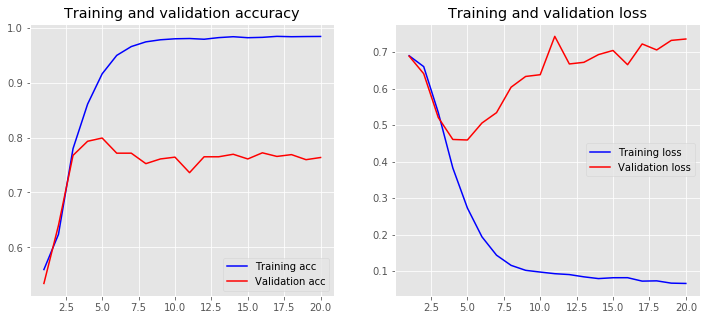

In [155]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=1,
                    validation_split=0.2,
                    batch_size=100)
plot_history(history)

### Use GloVe

In [156]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [210]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    '../models/glove/glove.twitter.27B.50d.txt',
    tokenizer.word_index, embedding_dim)

drop_out_prob = 0.5

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           weights = [embedding_matrix],
                           input_length=maxlen, 
                           trainable=False))
# model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(64, activation='relu',
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(layers.Dropout(drop_out_prob))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', learning_rate=0.001,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 100, 50)           905250    
_________________________________________________________________
global_average_pooling1d_17  (None, 50)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 64)                3264      
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 65        
Total params: 908,579
Trainable params: 3,329
Non-trainable params: 905,250
_________________________________________________________________


Train on 6851 samples, validate on 762 samples
Epoch 1/300
6851/6851 [==============================] - 1s 131us/sample - loss: 1.2504 - accuracy: 0.5458 - val_loss: 1.2199 - val_accuracy: 0.5341
Epoch 2/300
6851/6851 [==============================] - 0s 24us/sample - loss: 1.1983 - accuracy: 0.5660 - val_loss: 1.1707 - val_accuracy: 0.5341
Epoch 3/300
6851/6851 [==============================] - 0s 25us/sample - loss: 1.1482 - accuracy: 0.5783 - val_loss: 1.1252 - val_accuracy: 0.5341
Epoch 4/300
6851/6851 [==============================] - 0s 24us/sample - loss: 1.1034 - accuracy: 0.5767 - val_loss: 1.0832 - val_accuracy: 0.5341
Epoch 5/300
6851/6851 [==============================] - 0s 25us/sample - loss: 1.0629 - accuracy: 0.5764 - val_loss: 1.0444 - val_accuracy: 0.5341
Epoch 6/300
6851/6851 [==============================] - 0s 26us/sample - loss: 1.0259 - accuracy: 0.5760 - val_loss: 1.0088 - val_accuracy: 0.5341
Epoch 7/300
6851/6851 [==============================] - 0s 25us

Epoch 56/300
6851/6851 [==============================] - 0s 41us/sample - loss: 0.6336 - accuracy: 0.7208 - val_loss: 0.6300 - val_accuracy: 0.7336
Epoch 57/300
6851/6851 [==============================] - 0s 34us/sample - loss: 0.6317 - accuracy: 0.7295 - val_loss: 0.6285 - val_accuracy: 0.7362
Epoch 58/300
6851/6851 [==============================] - 0s 26us/sample - loss: 0.6298 - accuracy: 0.7307 - val_loss: 0.6282 - val_accuracy: 0.7336
Epoch 59/300
6851/6851 [==============================] - 0s 25us/sample - loss: 0.6282 - accuracy: 0.7281 - val_loss: 0.6266 - val_accuracy: 0.7362
Epoch 60/300
6851/6851 [==============================] - 0s 25us/sample - loss: 0.6289 - accuracy: 0.7345 - val_loss: 0.6249 - val_accuracy: 0.7493
Epoch 61/300
6851/6851 [==============================] - 0s 30us/sample - loss: 0.6277 - accuracy: 0.7352 - val_loss: 0.6247 - val_accuracy: 0.7362
Epoch 62/300
6851/6851 [==============================] - 0s 25us/sample - loss: 0.6266 - accuracy: 0.7320

Epoch 111/300
6851/6851 [==============================] - 0s 37us/sample - loss: 0.5936 - accuracy: 0.7576 - val_loss: 0.5843 - val_accuracy: 0.7808
Epoch 112/300
6851/6851 [==============================] - 0s 38us/sample - loss: 0.5955 - accuracy: 0.7541 - val_loss: 0.5838 - val_accuracy: 0.7808
Epoch 113/300
6851/6851 [==============================] - 0s 29us/sample - loss: 0.5951 - accuracy: 0.7562 - val_loss: 0.5829 - val_accuracy: 0.7769
Epoch 114/300
6851/6851 [==============================] - 0s 26us/sample - loss: 0.5926 - accuracy: 0.7584 - val_loss: 0.5818 - val_accuracy: 0.7795
Epoch 115/300
6851/6851 [==============================] - 0s 24us/sample - loss: 0.5919 - accuracy: 0.7567 - val_loss: 0.5819 - val_accuracy: 0.7808
Epoch 116/300
6851/6851 [==============================] - 0s 27us/sample - loss: 0.5911 - accuracy: 0.7597 - val_loss: 0.5807 - val_accuracy: 0.7756
Epoch 117/300
6851/6851 [==============================] - 0s 29us/sample - loss: 0.5921 - accuracy:

6851/6851 [==============================] - 0s 30us/sample - loss: 0.5732 - accuracy: 0.7717 - val_loss: 0.5579 - val_accuracy: 0.7874
Epoch 166/300
6851/6851 [==============================] - 0s 34us/sample - loss: 0.5751 - accuracy: 0.7632 - val_loss: 0.5583 - val_accuracy: 0.7900
Epoch 167/300
6851/6851 [==============================] - 0s 29us/sample - loss: 0.5719 - accuracy: 0.7708 - val_loss: 0.5573 - val_accuracy: 0.7913
Epoch 168/300
6851/6851 [==============================] - 0s 26us/sample - loss: 0.5739 - accuracy: 0.7708 - val_loss: 0.5566 - val_accuracy: 0.7940
Epoch 169/300
6851/6851 [==============================] - 0s 25us/sample - loss: 0.5727 - accuracy: 0.7667 - val_loss: 0.5561 - val_accuracy: 0.7927
Epoch 170/300
6851/6851 [==============================] - 0s 30us/sample - loss: 0.5727 - accuracy: 0.7669 - val_loss: 0.5557 - val_accuracy: 0.7913
Epoch 171/300
6851/6851 [==============================] - 0s 25us/sample - loss: 0.5701 - accuracy: 0.7667 - val_

Epoch 220/300
6851/6851 [==============================] - 0s 29us/sample - loss: 0.5580 - accuracy: 0.7726 - val_loss: 0.5402 - val_accuracy: 0.7900
Epoch 221/300
6851/6851 [==============================] - 0s 26us/sample - loss: 0.5600 - accuracy: 0.7752 - val_loss: 0.5388 - val_accuracy: 0.7966
Epoch 222/300
6851/6851 [==============================] - 0s 24us/sample - loss: 0.5586 - accuracy: 0.7755 - val_loss: 0.5390 - val_accuracy: 0.7900
Epoch 223/300
6851/6851 [==============================] - 0s 23us/sample - loss: 0.5541 - accuracy: 0.7723 - val_loss: 0.5385 - val_accuracy: 0.7874
Epoch 224/300
6851/6851 [==============================] - 0s 24us/sample - loss: 0.5572 - accuracy: 0.7735 - val_loss: 0.5376 - val_accuracy: 0.7966
Epoch 225/300
6851/6851 [==============================] - 0s 25us/sample - loss: 0.5555 - accuracy: 0.7685 - val_loss: 0.5377 - val_accuracy: 0.7900
Epoch 226/300
6851/6851 [==============================] - 0s 23us/sample - loss: 0.5578 - accuracy:

6851/6851 [==============================] - 0s 36us/sample - loss: 0.5498 - accuracy: 0.7755 - val_loss: 0.5250 - val_accuracy: 0.7992
Epoch 275/300
6851/6851 [==============================] - 0s 28us/sample - loss: 0.5462 - accuracy: 0.7789 - val_loss: 0.5270 - val_accuracy: 0.7913
Epoch 276/300
6851/6851 [==============================] - 0s 26us/sample - loss: 0.5482 - accuracy: 0.7759 - val_loss: 0.5253 - val_accuracy: 0.7966
Epoch 277/300
6851/6851 [==============================] - 0s 23us/sample - loss: 0.5443 - accuracy: 0.7834 - val_loss: 0.5249 - val_accuracy: 0.7979
Epoch 278/300
6851/6851 [==============================] - 0s 27us/sample - loss: 0.5454 - accuracy: 0.7757 - val_loss: 0.5246 - val_accuracy: 0.7979
Epoch 279/300
6851/6851 [==============================] - 0s 26us/sample - loss: 0.5475 - accuracy: 0.7824 - val_loss: 0.5234 - val_accuracy: 0.7992
Epoch 280/300
6851/6851 [==============================] - 0s 27us/sample - loss: 0.5498 - accuracy: 0.7764 - val_

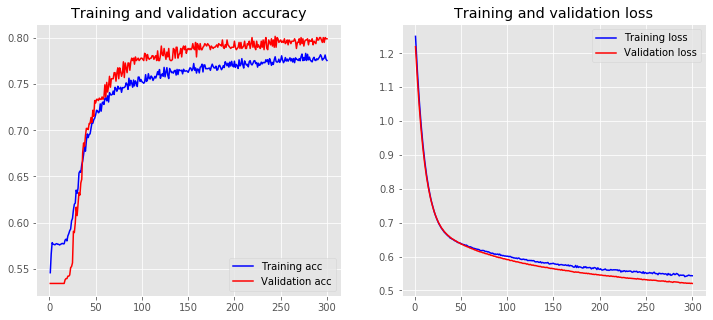

In [211]:
history = model.fit(X_train, y_train,
                    epochs=300,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=1000, use_multiprocessing=True)
plot_history(history)

## Bert

In [218]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint

In [214]:
%%time
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
embed = hub.KerasLayer(module_url, trainable=False, name='USE_embedding')

CPU times: user 27.7 s, sys: 5.54 s, total: 33.2 s
Wall time: 55.7 s


In [216]:
def build_model(embed):
    model = Sequential([
        layers.Input(shape=[], dtype=tf.string),
        embed,
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer = "adam", lr=0.0005, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [217]:
model = build_model(embed)
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_embedding (KerasLayer)   {'outputs': (None, 512)}  147354880 
_________________________________________________________________
dense_82 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)             

In [220]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    sent_data, labels_data,
    validation_split=0.2,
    epochs=20,
    callbacks=[checkpoint],
    batch_size=32
)

Train on 6090 samples, validate on 1523 samples
Epoch 1/20
6090/6090 [==============================] - 140s 23ms/sample - loss: 0.6000 - accuracy: 0.7435 - val_loss: 0.5807 - val_accuracy: 0.8011
Epoch 2/20
6090/6090 [==============================] - 80s 13ms/sample - loss: 0.4530 - accuracy: 0.8020 - val_loss: 0.4543 - val_accuracy: 0.8359
Epoch 3/20
6090/6090 [==============================] - 78s 13ms/sample - loss: 0.4107 - accuracy: 0.8228 - val_loss: 0.3853 - val_accuracy: 0.8424
Epoch 4/20
6090/6090 [==============================] - 76s 13ms/sample - loss: 0.3765 - accuracy: 0.8437 - val_loss: 0.3747 - val_accuracy: 0.8411
Epoch 5/20
6090/6090 [==============================] - 74s 12ms/sample - loss: 0.3598 - accuracy: 0.8463 - val_loss: 0.3796 - val_accuracy: 0.8411
Epoch 6/20
6090/6090 [==============================] - 73s 12ms/sample - loss: 0.3264 - accuracy: 0.8627 - val_loss: 0.3990 - val_accuracy: 0.8418
Epoch 7/20
6090/6090 [==============================] - 75s 12m

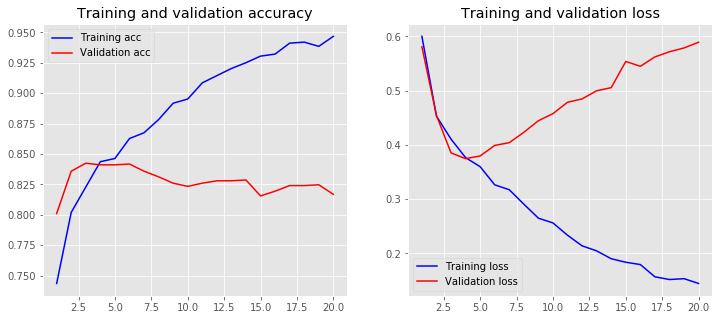

In [221]:
plot_history(history)

In [222]:
model.load_weights('model.h5')
test_pred = model.predict(sent_submission)

test_data['target'] = test_pred.round().astype(int)
submission = test_data[['id', 'target']]
submission.to_csv('submission.csv', index=False)

In [204]:
y_submission = model.predict(X_submission)
test_data['target'] = (y_submission > 0.5).astype(int)
submission = test_data[['id', 'target']]
submission.to_csv('submission.csv', index=False)

In [205]:
submission.target.value_counts()

0    2211
1    1052
Name: target, dtype: int64

In [125]:
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [131]:
submission

,id,target
0,0,1.0
1,2,1.0
2,3,1.0
3,9,1.0
4,11,1.0
...,...,...
3258,10861,1.0
3259,10865,1.0
3260,10868,1.0
3261,10874,0.0
